# E-distance of P1 and P2 Knockdown

1. Run through the 10x Cellranger pipeline and velocyto for single cell RNAseq quatification and using (2) guides quantifiction. all found in the cellranger files folder **bash**
2.  Guide Calling for dual guide. Use repogle method to take molecule.h5 generated by cellranger and py to run through repogle version of guide calling or use cellranger_guidecalling.ipynb for Direct Capture Perturb-Seq dual guide. Formed guide-specific lists of cells.
3. Pseudobulk analysis.
    A. Seperation of guide-specific fastq files. **bash**
    B. Whippet pseudobulk for transcript specific analysis, post UMI deduplication.  **bash**
    C. Transcript quality control. **R**
    D. Whippet result visualisation.

4. **Normalisation of adata object and E-distance of KD**
5. Check gene and neighboring gene expression
6. Create individual umaps per gene of interest 

    A. UMAPs 
    
    B. Rand Index score
7. Cell phase assignment model from FUCCI-matched single cell paper (GSE146773_)
8. Differential Expression analysis.

    A. Find the shared P1 and P2 genes. 

    B. Check the shared P1 and P2 across different protospacers with the same A/B and C/D.
    
9.  CNV Score & Numbat to quantify and Velocity quantification with loom file
10. ESR1-specific analysis from proliferation analysis to rt-qpcr
11.  Spectra analysis and visualisation for pathway enrichment



This script quantifies the global transcriptomic impact of each promoter-specific knockdown. This is done using the E-statistic (Energy distance), a metric better suited for the sparsity of single-cell data than traditional methods.

In [1]:
from tqdm.notebook import tqdm
from IPython.display import clear_output
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
from pyensembl import EnsemblRelease
from liftover import get_lifter
import os 
import sys
#import package from this locaton to be able to import /Users/helenking/Desktop/Weatheritt_Lab_Y2/alt-prom-crispr-fiveprime/scripts/apu_analysis
loc="/Users/helenking/Desktop/Weatheritt_Lab_Y2/alt-prom-crispr-fiveprime/"
fig_loc=loc+"figures/"

sys.path.append(loc+'scripts/')
from apu_analysis import *
import scperturb
import infercnvpy as cnv
from apu_analysis.cell_import import CellPopulation
import matplotlib.pyplot as plt
# colours using garvan 
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'

#use viridis
color1="#fde725"
color2="#7ad151"
color3="#22a884"
color4="#2a788e"
color5="#2a788e"
color6='#440154'

#hotpink yellow and blue
color1='#d81b61' #true
color2='#fec111' #false
color3='#2179b4' #negative control

#protein level
color1='#3d82c4' #true
color2='#2179b4' #false

# Create the color palette
palette = sns.color_palette([color1, color2,color3])
new_palette = sns.color_palette([color1, color2,color1, color2,color1, color2,color1, color2,color1, color2,color1, color2, color3, color4])
whippet_loc = "/Users/helenking/Library/CloudStorage/OneDrive-UNSW/PAPERS/CRISPRi_paper/Updated_FullLength/NAR_rebuttal/Supplementary_Information/Table_S4.xlsx"


print("Scanpy", sc.__version__)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


Scanpy 1.10.3


/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Rather than looking at individual genes one by one, the code uses the e-distance to measure how much the entire transcriptome of a cell population changes after a specific promoter (P1 or P2) is knocked down compared to a control.





Dimensionality Reduction: The code first performs Principal Component Analysis (PCA) and UMAP embedding on the normalized single-cell data.


E-test Calculation: Using the scPerturb package, it calculates the Euclidean distance between these high-dimensional clusters. A significant e-distance indicates that the promoter knockdown created a unique "transcriptional landscape" distinct from the control.

In [2]:
##this reads in the output from 10x as well as cell_indetities.csv which is a file that annotates each cell barcode with a 
#cell_barcode,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells
pop = CellPopulation.from_file(loc+'cellranger_output',
                               genome='', filtered=True,raw_umi_threshold=100)
strip_low_expression(pop) 

#create list of nontargeting guides
nontargeting_control=[v for v in pop.cells["guide_identity"] if (str(v).startswith("Neg")|str(v).startswith("non")|str(v).startswith("Non")| str(v).startswith("sgNegC"))]
non_targeting_list=list(dict.fromkeys(nontargeting_control))

#add perturbation column to the pop.cells dataframe
pop.cells["perturbation"]=np.where(pop.cells["guide_identity"].isin(non_targeting_list),"non-targeting",pop.cells["guide_identity"].str.split("_").str.get(0).str.split("sg").str.get(1))

#seperately annotate the positive control guides
pos_control=[v for v in pop.cells["guide_identity"] if (str(v).startswith("sgRPL3")|str(v).startswith("sgSNRPD")|str(v).startswith("sgATF5")|str(v).startswith("sgGINS1")|str(v).startswith("sgRPL31A")|str(v).startswith("sgSNRPD"))]
pop.cells["perturbation"]=np.where(pop.cells["guide_identity"].isin(pos_control),pop.cells["perturbation"].str[:-1],pop.cells["perturbation"])

#add a column for the promoter type
pop.cells["promoter_type"]=pop.cells["guide_identity"].str.split("_").str.get(1).str[:2]
pop.cells["promoter_type"][(pop.cells["promoter_type"]=="00") | (pop.cells["promoter_type"]=="01") | (pop.cells["promoter_type"]=="02") | (pop.cells["promoter_type"]=="03")] = "Control"
pop.cells=pop.cells.drop_duplicates()
#add certain filters and add information
pop.cells=add_filter_columns(input_dataframe=pop.cells)
print(pop.cells.shape, pop.cells["cell_barcode"].nunique())

Loading digital expression data: /Users/helenking/Desktop/Weatheritt_Lab_Y2/alt-prom-crispr-fiveprime/cellranger_output/filtered_feature_bc_matrix/matrix.mtx...
Densifying matrix...
Loading guide identities:/Users/helenking/Desktop/Weatheritt_Lab_Y2/alt-prom-crispr-fiveprime/cellranger_output/cell_identities.csv...
Generating summary statistics...
Done.
(28365, 25) 28365


In [3]:
%%capture
adata = ad.read_h5ad(loc+"/files/adata_normalised_cellcycle.h5ad")
adata.X=adata.layers["log1p"]

In [4]:
if 'processed' in adata.uns.keys():
    print('The dataset is already processed. Skipping processing...')
else:
  adata = ad.AnnData(pop.matrix.loc[pop.cells["cell_barcode"]])
  adata.obs = pop.cells
  adata.var_names = pop.matrix.columns
  adata.obs_names = adata.obs["cell_barcode"].values
  adata.X=adata.X.astype('float32')
  adata.var_names_make_unique()
  #remove any na values from 
  adata = adata[~(adata.obs["guide_id"].isna()),:]
  #remove all genes that start with sg 
  adata=adata[:,~((adata.var_names.str.startswith('sg'))|(adata.var_names.str.startswith('non'))|(adata.var_names.str.startswith('Non')))]
  whippet=pd.read_excel("/Supplementary_Information/Table_S4.xlsx")
  adata.obs['guide_target']=np.where(adata.obs['guide_target'].str.startswith("sg"),adata.obs['guide_target'].str[2:],"non-targeting")
  #merge on the lhs with whippet
  adata.obs=adata.obs.merge(whippet, left_on="guide_target",right_on="gene",how="left")
  adata.obs["successfulKD"]=adata.obs["successfulKD"].astype('str')
  adata.obs_names = adata.obs["cell_barcode"].values

  #import another
  adata2 = sc.read_10x_mtx("alt-prom-crispr-fiveprime/cellranger_output/filtered_feature_bc_matrix")
  #add pop2 to pop #get the same genes and cells as adata 
  #list of genes found in both 
  genes = list(set(adata.var_names) & set(adata2.var_names))
  #list of cells found in both
  cells = list(set(adata.obs_names) & set(adata2.obs_names))
  adata=adata[cells,genes]
  adata2=adata2[cells,genes]
  #add the X from adata2 to adata
  adata.X=adata.X + adata2.X
  adata.layers['counts'] = adata.X.copy()
  mitochondrial_genes=sc.queries.mitochondrial_genes("hsapiens",attrname="hgnc_symbol")
  adata.var['mt'] = adata.var_names.isin(mitochondrial_genes["hgnc_symbol"]) # annotate the group of mitochondrial genes as 'mt'
  sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

  # basic qc and pp
  sc.pp.filter_cells(adata, min_counts=1000)
  sc.pp.normalize_per_cell(adata)
  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.filter_genes(adata, min_cells=50)
  sc.pp.log1p(adata)
  #save the log1p normalised matrix
  adata.layers['log1p'] = adata.X.copy()

  adata = adata[adata.obs["pct_counts_mt"] < 10, adata.var['mt']==False] 
  sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

  # select HVGs
  n_var_max = 2000  # max total features to select

  sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
  sc.pp.pca(adata, use_highly_variable=True)
  sc.pp.neighbors(adata)
  adata.uns['processed'] = True
  adata.obs["good_coverage"]=adata.obs["good_coverage"].astype("category")
  adata.write_h5ad(loc+"files/adata_normalised.h5ad")

The dataset is already processed. Skipping processing...


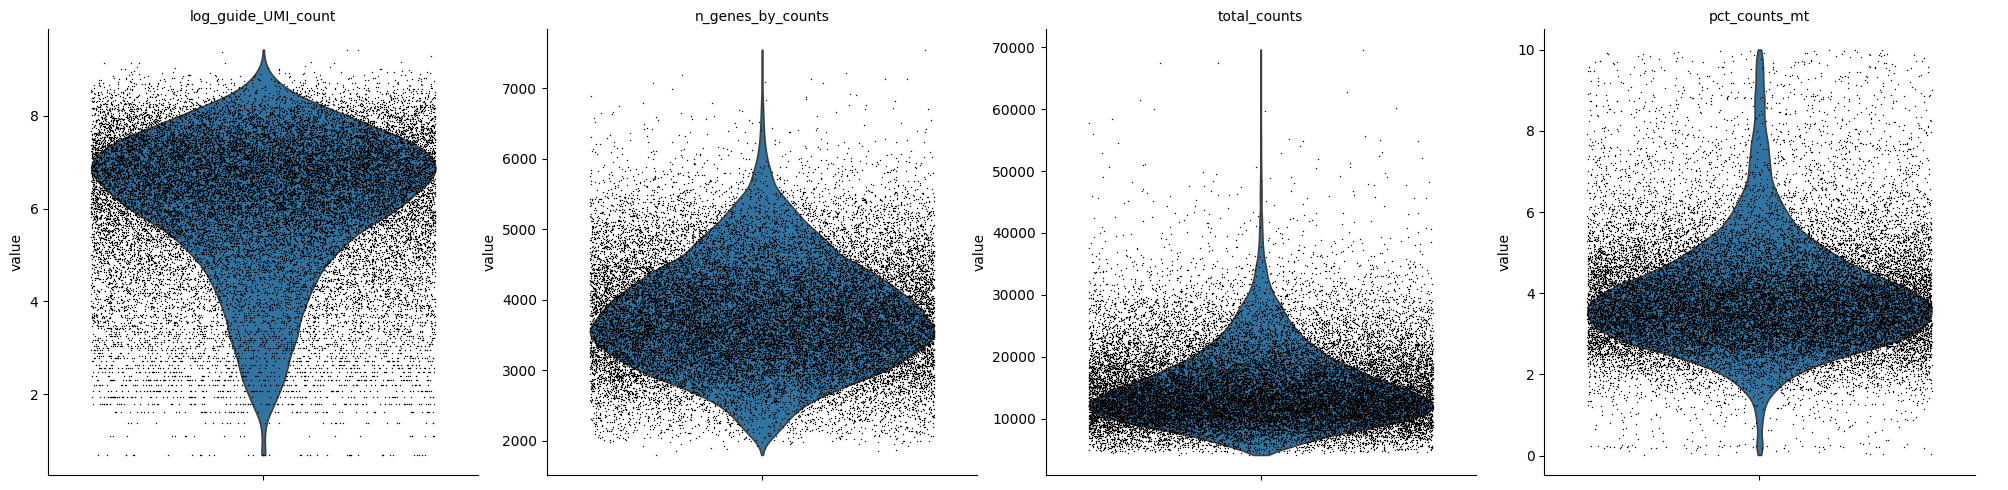

In [5]:
adata.obs["log_guide_UMI_count"]=np.log1p(adata.obs["guide_UMI_count"])
# adata.write_csvs(loc+'files/adata_normalised/')
sc.pl.violin(
    adata,
    ["log_guide_UMI_count","n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True, save = "qc.png"
)


<Axes: xlabel='highly_variable', ylabel='pct_dropout_by_counts'>

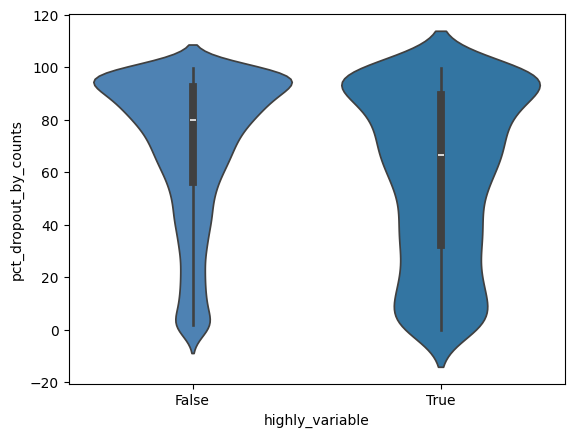

In [6]:
sns.violinplot(x="highly_variable", y="pct_dropout_by_counts", data=adata.var, palette=new_palette)

In [7]:
list_twoprom=adata.obs.groupby(["perturbation"])["promoter_type"].nunique() == 2
adata.obs["two"]=adata.obs["perturbation"].isin(list_twoprom[list_twoprom==True].index)
#apply the function to every gene that has both MP and AP promoter type
#create a column to chekc if both AP and MP 
perturb= adata.obs["perturbation"][(adata.obs["perturbation"]!="non-targeting") & (adata.obs["two"]==True)]
perturb=perturb.unique()
#choose the 
grouping_variable="guide_id"
negative_control="non-targeting_Control"


In [8]:

if os.path.exists(loc+"files/edist_perprom.csv"):
    #read in the edistcsv
    df=pd.read_csv(loc+"files/edist_perprom.csv", index_col=0)
    ##remove the non-targeting guides
    df = df[df["pvalue"]!=1]
    df["gene"]=df.index.str.split("_").str.get(0)
    df['neglog10_pvalue_adj'] = -np.log10(df['pvalue_adj'])
    #import the gene to 5' UTR annotation file
    nterm=pd.read_table(loc+"/files/reference/all_pivot_simple_nterm.txt")
    #color the violin plot above with the 5'UTR annotation
    df=nterm.merge(df, left_on="Gene_symbol",right_on="gene",how="right").sort_values(by="edist")
    df.index=df["gene"]
    whippet=pd.read_excel(whippet_loc)
    df=df.merge(whippet,right_on="gene",left_index=True,how="right")
    # df=df[df["successfulKD"]==True] 
else:
    df_list=[test_edist_perprom(adata, gene, grouping_variable, negative_control) for gene in perturb]   
    #flatten the df_list 
    df=pd.concat(df_list)
    df.to_csv(loc+"files/edist_perprom.csv")

Comparative Analysis of P1 vs. P2 Knockdowns
A major goal of the paper is to see if P1 and P2 promoters of the same gene do different things.





Direct Comparison: The notebook computes the e-distance between the P1-targeted population and the P2-targeted population.




Results Found: The authors report that 51.6% (16/31) of surveyed genes showed significant transcriptomic divergence between P1 and P2 knockdowns. This proves that these alternative promoters are not redundant but regulate different biological pathways


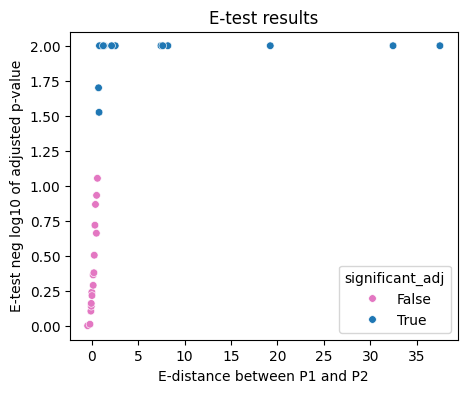

In [9]:

fig, ax = pl.subplots(1,1, figsize=[5,4])

scat=sns.scatterplot(data=df[df["successfulKD"]==True], y='neglog10_pvalue_adj', x='edist', hue='significant_adj', 
                     palette={True: 'tab:blue', False: 'tab:pink', 'Non-Targeting': 'tab:orange'}, s=30)
plt.title('E-test results')
plt.xlabel('E-distance between P1 and P2')
plt.ylabel('E-test neg log10 of adjusted p-value')
scat.figure.savefig(fig_loc+"etest_pvalue_adj.pdf")

plt.show()


Biological and Structural Annotations
The code merges statistical results with biological data to interpret the findings:


N-Terminus Changes: It checks if the start codon (ATG) is located between the two promoters. If it is, the P1 and P2 transcripts will produce different protein isoforms, likely leading to the observed divergence in the e-statistic.




Clustering Performance: The code uses Rand Scores and Mutual Information Scores to evaluate how well unsupervised clustering (like HDBSCAN) can distinguish between P1 and P2 cells.

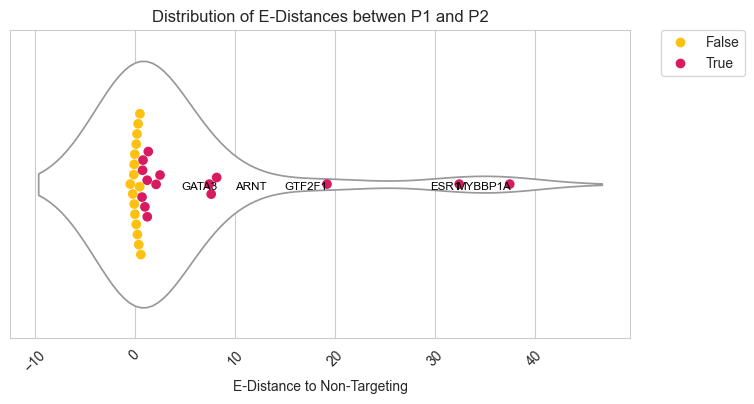

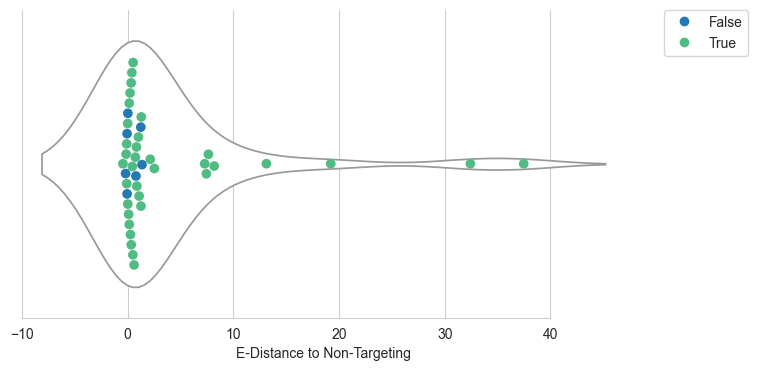

In [10]:
sns.set_style("whitegrid")
#put two colors d81b61 fec111
palette_new={True: "#d81b61", False: "#fec111"}
fig, ax1 = plt.subplots(1, 1, figsize=(8,4))
plt.setp(ax.collections, alpha=.8)
sns.violinplot(data=df[df["successfulKD"]==True], x='edist', inner=None,  color="white",  ax=ax1)
sns.swarmplot(data=df[df["successfulKD"]==True],   x='edist', size=7,ax=ax1,  hue='significant_adj',dodge=False,palette=palette_new)


for i in df[df["significant_adj"]==True].sort_values("edist").tail(n=5).index:
    ax1.text(df.loc[i,"edist"]+(np.random.random(1)*0.1), 0.02,df.loc[i,"gene"], horizontalalignment='right', size='small', color='black')

plt.xticks(rotation=45)
plt.yticks([0], [''])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#label esr1
plt.xlabel('E-Distance to Non-Targeting')
plt.title('Distribution of E-Distances betwen P1 and P2')

sns.set_style("whitegrid")

fig.figure.savefig(fig_loc+"edistance_violinplot.pdf")
plt.show()

sns.set_style("whitegrid")
#change palette_two 5UTR #2279b4 Nterminus #50bc83
palette_two={False: "#2279b4", True: "#50bc83"}
fig, ax1 = plt.subplots(1, 1, figsize=(8,4))
plt.setp(ax.collections, alpha=.3)
sns.violinplot(data=df, x='edist', inner=None, color="white",  ax=ax1)
sns.despine(trim=True, left=True)
sns.swarmplot(data=df,  x='edist', size=7,ax=ax1,  hue='Nterminus_Change',dodge=False,palette=palette_two)

plt.yticks([0], [''])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.xlabel('E-Distance to Non-Targeting')
fig.figure.savefig(fig_loc+"edistance_violinplot_utr.pdf")
plt.show()

df.to_csv(loc+"files/edist_results.csv")
#extract the significant genes above 
significant_genes=df[df["significant_adj"]==True].sort_values("edist")
significant_genes.to_csv(loc+"files/significant_genes.csv")

In [11]:
#save df to Downloads
df.to_csv("/Users/helenking/Downloads/edist_results_full.csv")

Correlation with Promoter Usage
The authors use this notebook to investigate if the "strength" of a promoter (its baseline TPM) predicts its functional impact.



Key Findings: The analysis (visualized in pairwise correlation matrices) showed no meaningful correlation between a promoter's usage fraction and the resulting e-distance. This means even a weakly expressed alternative promoter can trigger a massive global change in the cell's transcriptome

In [12]:
# --- column names for P1 ---
x_p1 = 'edist'
y_p1 = '% KD of Non-Targeted P1 Isoforms against NTC'

# --- column names for P2 ---
x_p2 = 'edist'
y_p2 = '% KD of Non-Targeted P2 Isoforms against NTC'

# significance column
sig_col = 'significant'

# label column
label_col = 'Gene_symbol'

# Convert all relevant columns to numeric
for col in [x_p1, y_p1, y_p2]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Keep only rows with data
df_clean = df[[x_p1, y_p1, y_p2, sig_col, label_col]].dropna()

# --- Remove problematic values for log-scale ---
# log-scale cannot handle 0, negative, or extremely small e-distances
df_clean = df_clean[df_clean[x_p1] > 1e-6]

# Detect outliers using IQR
def find_outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return (series < lower) | (series > upper)

df_clean['outlier_p1'] = find_outliers(df_clean[y_p1])
df_clean['outlier_p2'] = find_outliers(df_clean[y_p2])

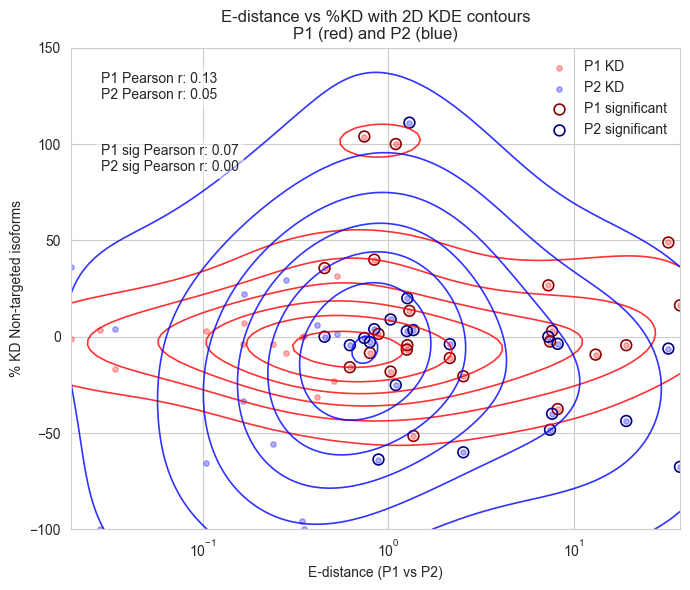

P1 Pearson r: 0.13
P2 Pearson r: 0.05
P1 sig Pearson r: 0.07
P2 sig Pearson r: 0.00


In [13]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

# Pull arrays
x = df_clean[x_p1].values          # e-distance (same for P1 & P2)
y1 = df_clean[y_p1].values         # %KD P1
y2 = df_clean[y_p2].values         # %KD P2
sig = df_clean[sig_col].values     # boolean significance

# Keep only positive x for log scale
mask = x > 0
x = x[mask]
y1 = y1[mask]
y2 = y2[mask]
sig = sig[mask]

# Work in log10(x) space for KDE stability
x_log = np.log10(x)

# Grid for KDE evaluation
xmin, xmax = x_log.min(), x_log.max()
ymin = min(y1.min(), y2.min())
ymax = max(y1.max(), y2.max())

xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]

# 2D KDE for P1
kde1 = gaussian_kde(np.vstack([x_log, y1]))
z1 = kde1(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

# 2D KDE for P2
kde2 = gaussian_kde(np.vstack([x_log, y2]))
z2 = kde2(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

# Convert grid x back to linear scale for plotting
x_grid = 10**xx

fig, ax = plt.subplots(figsize=(7, 6))

# --- KDE contours (sns.kdeplot-style) --- #
# P1: red contour lines
c1 = ax.contour(
    x_grid, yy, z1,
    levels=7,
    colors="red",
    linewidths=1.2,
    alpha=0.8,
)

# P2: blue contour lines
c2 = ax.contour(
    x_grid, yy, z2,
    levels=7,
    colors="blue",
    linewidths=1.2,
    alpha=0.8,
)

# --- Scatter points --- #
# Light, semi-transparent points
ax.scatter(x, y1, c="red", s=15, alpha=0.3, label="P1 KD")
ax.scatter(x, y2, c="blue", s=15, alpha=0.3, label="P2 KD")

# Highlight significant e-distance points with outlined markers
ax.scatter(
    x[sig], y1[sig],
    facecolors="none", edgecolors="darkred",
    s=60, linewidth=1.2, label="P1 significant"
)
ax.scatter(
    x[sig], y2[sig],
    facecolors="none", edgecolors="navy",
    s=60, linewidth=1.2, label="P2 significant"
)

# Axes & labels
ax.set_xscale("log")
ax.set_xlabel("E-distance (P1 vs P2)")
ax.set_ylabel("% KD Non-targeted isoforms")
ax.set_title("E-distance vs %KD with 2D KDE contours\nP1 (red) and P2 (blue)")
ax.set_ylim(-100, 150)
#add correlation
from scipy.stats import pearsonr
corr_p1, _ = pearsonr(x, y1)
corr_p2, _ = pearsonr(x, y2)
ax.text(0.05, 0.95, f'P1 Pearson r: {corr_p1:.2f}\nP2 Pearson r: {corr_p2:.2f}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
       )
# add correlation for significant points only
corr_p1_sig, _ = pearsonr(x[sig], y1[sig])
corr_p2_sig, _ = pearsonr(x[sig], y2[sig])
ax.text(0.05, 0.80, f'P1 sig Pearson r: {corr_p1_sig:.2f}\nP2 sig Pearson r: {corr_p2_sig:.2f}',    
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
       )
ax.legend(frameon=False)
#save
fig.savefig(fig_loc+"edistance_kde_contours_off.pdf")
plt.tight_layout()
plt.show()
#print all the correlatiosn
print(f'P1 Pearson r: {corr_p1:.2f}\nP2 Pearson r: {corr_p2:.2f}')
print(f'P1 sig Pearson r: {corr_p1_sig:.2f}\nP2 sig Pearson r: {corr_p2_sig:.2f}')

In [14]:
if os.path.exists(loc+"/files/singlecell_shortread_analysis/edistance_full_all.csv"):
    print("Already run edistance and etest between negative control and all other guides")
    df = pd.read_csv(loc+"/files/singlecell_shortread_analysis/edistance_full_all.csv", index_col=0)
    df = df[df["pvalue"]!=1]
    df["gene"]=df.index.str.split("_").str.get(0)
    df['neglog10_pvalue_adj'] = -np.log10(df['pvalue_adj'])
    df.index=df["gene"]
    whippet=pd.read_excel(whippet_loc)
    df=df.merge(whippet,right_on="gene",left_index=True,how="right")
else:
    #rerun the same as above but instead of between 
    grouping_variable="guide_id"
    negative_control="non-targeting_Control"

    # grouping_variable="guide_assignment"
    # negative_control="non-targeting"
    adata_sgRNA=adata
    adata_sgRNA.obs["guide_assignment"]=np.where(adata_sgRNA.obs["guide_target"]=="non-targeting","non-targeting",adata_sgRNA.obs["guide_assignment"])
    data_sgRNA = scperturb.equal_subsampling(adata_sgRNA, grouping_variable, N_min=80)
    sc.pp.filter_genes(data_sgRNA, min_cells=3)  # sanity cleaning

    # select HVGs
    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(data_sgRNA, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.pca(data_sgRNA, use_highly_variable=True)
    sc.pp.neighbors(data_sgRNA)
    estats = scperturb.edist(adata_sgRNA,obs_key=grouping_variable, obsm_key='X_pca', dist='sqeuclidean')
    df = scperturb.etest(adata_sgRNA, obs_key=grouping_variable, obsm_key='X_pca', dist='sqeuclidean', control=negative_control, alpha=0.05, runs=10000, n_jobs=-1)
    #filter df
    df.to_csv(loc+"/files/singlecell_shortread_analysis/edistance_full_all.csv")
    #save two versions one per guide and one per perturbation
    # df = pd.read_csv(loc+"/files/singlecell_shortread_analysis/edistance_full_all.csv")
        # index=tuple(zip(estats.index.str.split('_').str[0].to_list(),estats.index.str.split('_').str[1].to_list()))
    columns=tuple(zip(estats.columns.str.split('_').str[0].to_list(),estats.columns.str.split('_').str[1].to_list()))
    estats.index = pd.MultiIndex.from_tuples(index) 
    estats.columns = pd.MultiIndex.from_tuples(columns) 
    fig, ax = pl.subplots(1,1, figsize=[5,4])
    order = estats.sort_index().index
    order_estats=estats.loc[order, order]
    order_estats.index = order_estats.index.droplevel(1)
    order_estats.columns = order_estats.columns.droplevel(1)

    sns_plot = sns.heatmap(order_estats, cmap='viridis', ax=ax, cbar_kws={'label': 'E-distance'})
    #save to pdf
    sns_plot.figure.savefig(fig_loc+"edistance_heatmap.pdf")


    ax.set(xlabel="", ylabel="")

Already run edistance and etest between negative control and all other guides


In [15]:
df = pd.read_csv(loc+"/files/singlecell_shortread_analysis/edistance_full_all.csv", index_col=0)
df["promoter"]=np.where(df.index.str.split("_").str.get(1)=="MP","P1","P2")
df["gene"]=df.index.str.split("_").str.get(0)
df = df[df["pvalue"]!=1]
df["edist_neg"]=np.where(df["promoter"]=="P2",-df["edist"],df["edist"])

#split edist to be p1 and p2 
df=df.pivot(index="gene",columns="promoter",values=["edist","edist_neg","pvalue","significant","pvalue_adj","promoter"])
#change the columns to be flattened 
df.columns = ['_'.join(col).strip() for col in df.columns.values]
# df['neglog10_pvalue_adj_P1'] = -np.log10(df['pvalue_adj_P1'],where=df['pvalue_adj_P1']!=0)
# df['neglog10_pvalue_adj_P2'] = -np.log10(df['pvalue_adj_P2'], where=df['pvalue_adj_P2']!=0)
df["gene"]=df.index
df.reset_index(drop=True, inplace=True)



#repeat with the ntc relative to the other guides
df_2 = pd.read_csv(loc+"/files/singlecell_shortread_analysis/edist_perprom.csv", index_col=0)
#remove the non-targeting guides
df_2 = df_2[df_2["pvalue"]!=1]
df_2["gene"]=df_2.index.str.split("_").str.get(0)
df_2['neglog10_pvalue_adj'] = -np.log10(df_2['pvalue_adj'])
#merge the two dataframes
df=df.merge(df_2, on="gene", how="right", suffixes=('', '_ntc'))

#repeat with 1000
df_3 = pd.read_csv(loc+"/files/singlecell_shortread_analysis/edist_perprom_10000.csv", index_col=0)
#remove the non-targeting guides
df_3 = df_3[df_3["pvalue"]!=1]
df_3["gene"]=df_3.index.str.split("_").str.get(0)
df_3['neglog10_pvalue_adj'] = -np.log10(df_3['pvalue_adj'])
#merge the two dataframes
df=df.merge(df_3, on="gene", how="right", suffixes=('', '_ten'))
whippet=pd.read_excel(whippet_loc)
df=df.merge(whippet,on="gene",how="right")
#if the promoter is P2 then the edist is negative
df_melt=df[["gene","successfulKD","edist_neg_P1","significant_P1"]]
df_melt.columns=["gene","successfulKD","edist_neg","significant"]
df_melt["promoter"]="P1"
df_melt_2=df[["gene","successfulKD","edist_neg_P2","significant_P2"]]
df_melt_2.columns=["gene","successfulKD","edist_neg","significant"]
df_melt_2["promoter"]="P2"
df_melt=pd.concat([df_melt,df_melt_2])

df_melt

,gene,successfulKD,edist_neg,significant,promoter
0,ADAR,True,0.3534,True,P1
1,AHCYL1,True,0.7402,True,P1
2,APP,True,0.3667,True,P1
3,ARNT,False,9.8101,True,P1
4,BRIP1,True,10.0487,True,P1
...,...,...,...,...,...
37,STAU2,False,-0.1702,False,P2
38,TGIF1,True,-1.5769,True,P2
39,TPD52L1,False,-0.9610,True,P2
40,YWHAZ,True,-1.8761,True,P2


Text(0, 0.5, 'Gene (Successful KD)')

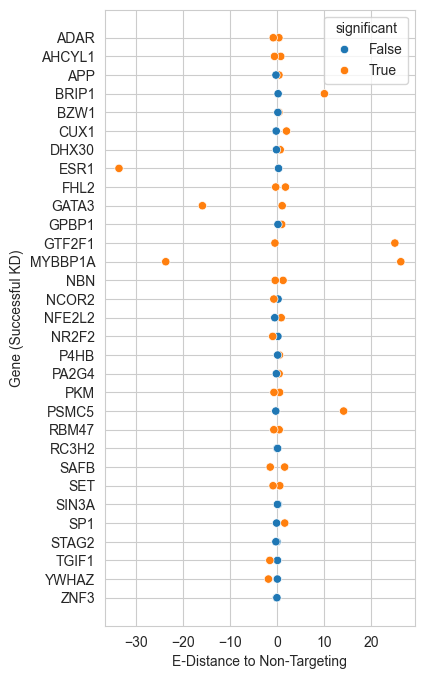

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(4,8))
#show the esr1 gene with x and y of 
sns.scatterplot(data=df_melt[df_melt["successfulKD"]==True], y='gene', x='edist_neg', hue='significant')
plt.xlabel('E-Distance to Non-Targeting')
plt.ylabel('Gene (Successful KD)')

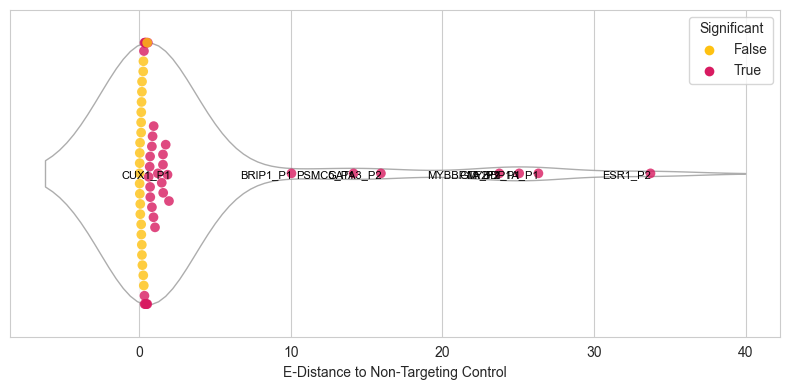

In [17]:
df_melt["gene_promoter"]=df_melt["gene"]+"_"+df_melt["promoter"]
# 1) Ensure a single numeric 'edist' column
df_melt = df_melt.copy()
df_melt["edist"] = pd.to_numeric(np.abs(df_melt["edist_neg"]), errors="coerce")

# 2) Remove duplicate columns (keeps first occurrence)
if df_melt.columns.duplicated().any():
    df_melt = df_melt.loc[:, ~df_melt.columns.duplicated()]

subset = df_melt[df_melt["successfulKD"]].dropna(subset=["edist"])

palette_new = {True: "#d81b61", False: "#fec111"}

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(8, 4))

# Horizontal orientation so edist is on X
sns.violinplot(data=subset, x="edist", inner=None, color="white", linewidth=1,
               orient="h", ax=ax1)
sns.swarmplot(data=subset, x="edist", hue="significant", dodge=False, size=7,
              palette=palette_new, orient="h", ax=ax1)

# Slight transparency
for coll in ax1.collections:
    try: coll.set_alpha(0.8)
    except Exception: pass

# 3) Label top-5 by edist (force scalar extraction)
top5 = subset.sort_values("edist").tail(8)
for _, row in top5.iterrows():
    # convert to scalar robustly even if something odd slips in
    ed = np.asarray(row["edist"]).astype(float).ravel()[0]
    jitter = np.random.rand() * 0.1
    ax1.text(ed + jitter, 0.02, str(row["gene_promoter"]),
             ha="right", va="bottom", fontsize=8, color="black")

ax1.set_xlabel("E-Distance to Non-Targeting Control")
ax1.set_ylabel("")
ax1.legend(title="Significant", loc="upper right")
#save to pdf
fig.figure.savefig(fig_loc+"edistance_violinplot_perpromoter_ntc.pdf")
plt.tight_layout()
plt.show()

In [18]:
top5

,gene,successfulKD,edist_neg,significant,promoter,gene_promoter,edist
8,CUX1,True,1.9719,True,P1,CUX1_P1,1.9719
4,BRIP1,True,10.0487,True,P1,BRIP1_P1,10.0487
26,PSMC5,True,14.1426,True,P1,PSMC5_P1,14.1426
12,GATA3,True,-15.9471,True,P2,GATA3_P2,15.9471
17,MYBBP1A,True,-23.7559,True,P2,MYBBP1A_P2,23.7559
14,GTF2F1,True,25.0637,True,P1,GTF2F1_P1,25.0637
17,MYBBP1A,True,26.3313,True,P1,MYBBP1A_P1,26.3313
10,ESR1,True,-33.7209,True,P2,ESR1_P2,33.7209


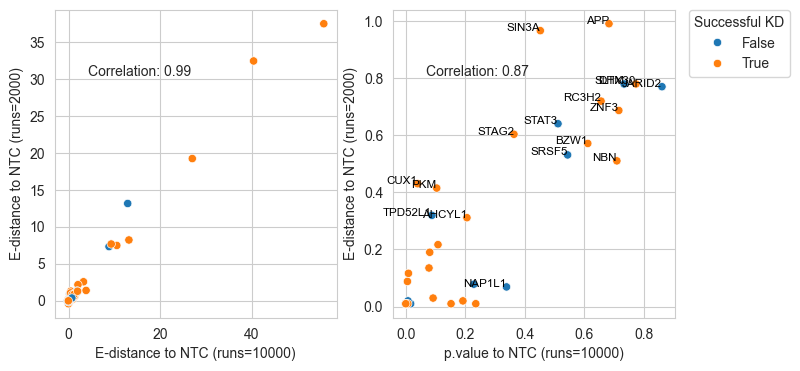

In [19]:
#plot two scatterplot 
fig, ax1 = plt.subplots(1, 2, figsize=(8,4))
#plot edistance p1 and p2 
sns.scatterplot(data=df, y='edist', x='edist_ten', hue='successfulKD', ax=ax1[0])
#hide the legend
ax1[0].get_legend().remove()
#plot the correlation between the two
corr=df[["edist","edist_ten"]].corr()
plt.text(0.3, 0.8, f'Correlation: {corr.iloc[0,1]:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax1[0].transAxes)
#plot the pvalue adj
sns.scatterplot(data=df, y='pvalue_adj', x='pvalue_adj_ten', hue='successfulKD', ax=ax1[1])
corr=df[["pvalue_adj","pvalue_adj_ten"]].corr()
#mvoe the legend outisde 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Successful KD") 
plt.text(0.3,  0.8, f'Correlation: {corr.iloc[0,1]:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax1[1].transAxes)
#label the points that are outliers from the correlation
#change the x-axis 
ax1[0].set_xlabel("E-distance to NTC (runs=10000)")
ax1[0].set_ylabel("E-distance to NTC (runs=2000)")
ax1[1].set_xlabel("p.value to NTC (runs=10000)")
ax1[1].set_ylabel("E-distance to NTC (runs=2000)")
for i in df[(df["pvalue_adj"]>0.3) | (df["pvalue_adj_ten"]>0.3)].index:
    ax1[1].text( df.loc[i,"pvalue_adj_ten"],df.loc[i,"pvalue_adj"],df.loc[i,"gene"], horizontalalignment='right', size='small', color='black')
plt.show()

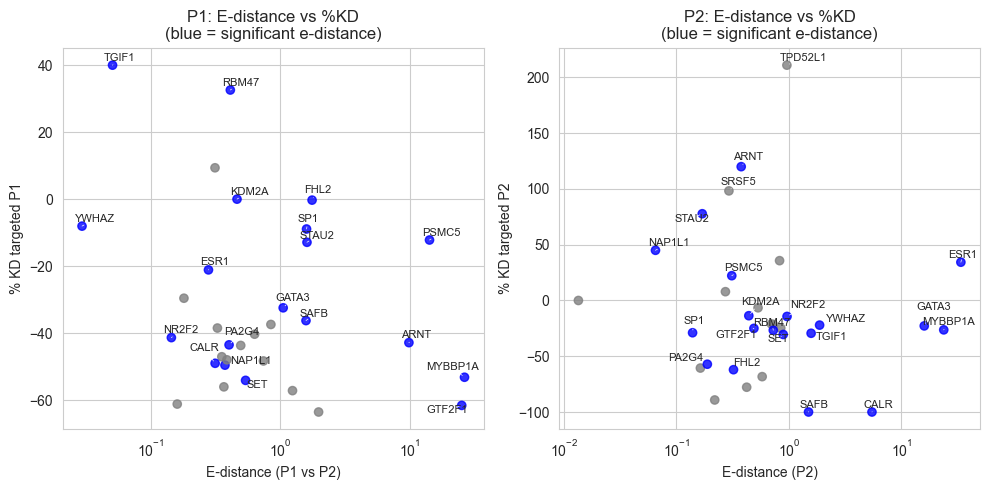

In [21]:
# --- column names for P1 ---
x_p1 = 'edist_P1'
y_p1 = '% KD of targeted P1 Isoforms against NTC'

# --- column names for P2 ---
x_p2 = 'edist_P2'
y_p2 = '% KD of Targeted P2 Isoforms against NTC'

# significance column
sig_col = 'significant'

# label column
label_col = 'gene'

# Convert all relevant columns to numeric
for col in [x_p1, y_p1, x_p2, y_p2]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Keep only rows with data
df_clean = df[[x_p1, y_p1, x_p2, y_p2, sig_col, label_col]].dropna()
# --- Remove problematic values for log-scale ---
# log-scale cannot handle 0, negative, or extremely small e-distances
df_clean = df_clean[(df_clean[x_p1] > 1e-6) & (df_clean[x_p2] > 1e-6)]

# Detect outliers using IQR
def find_outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return (series < lower) | (series > upper)

df_clean['outlier_p1'] = find_outliers(df_clean[y_p1])
df_clean['outlier_p2'] = find_outliers(df_clean[y_p2])
from adjustText import adjust_text
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# -------- P1 panel -------- #
ax = axes[0]

ax.scatter(
    df_clean[x_p1], df_clean[y_p1],
    c=df_clean[sig_col].map({True: "blue", False: "gray"}),
    alpha=0.8
)

label_mask = df_clean[sig_col] | df_clean['outlier_p1']
texts = []
for _, row in df_clean[label_mask].iterrows():
    t = ax.text(
        row[x_p1], row[y_p1],
        row[label_col],
        fontsize=8, ha='center', va='bottom'
    )
    texts.append(t)

ax.set_xscale('log')
ax.set_xlabel("E-distance (P1 vs P2)")
ax.set_ylabel("% KD targeted P1")
ax.set_title("P1: E-distance vs %KD\n(blue = significant e-distance)")

# Let adjustText move labels to avoid overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", lw=0.5))

# -------- P2 panel -------- #
ax = axes[1]

ax.scatter(
    df_clean[x_p2], df_clean[y_p2],
    c=df_clean[sig_col].map({True: "blue", False: "gray"}),
    alpha=0.8
)

label_mask = df_clean[sig_col] | df_clean['outlier_p2']
texts = []
for _, row in df_clean[label_mask].iterrows():
    t = ax.text(
        row[x_p2], row[y_p2],
        row[label_col],
        fontsize=8, ha='center', va='bottom'
    )
    texts.append(t)

ax.set_xscale('log')
ax.set_xlabel("E-distance (P2)")
ax.set_ylabel("% KD targeted P2")
ax.set_title("P2: E-distance vs %KD\n(blue = significant e-distance)")

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", lw=0.5))

plt.tight_layout()
plt.show()


P1 Pearson r: -0.21
P2 Pearson r: 0.02
P1 sig Pearson r: -0.39
P2 sig Pearson r: 0.06


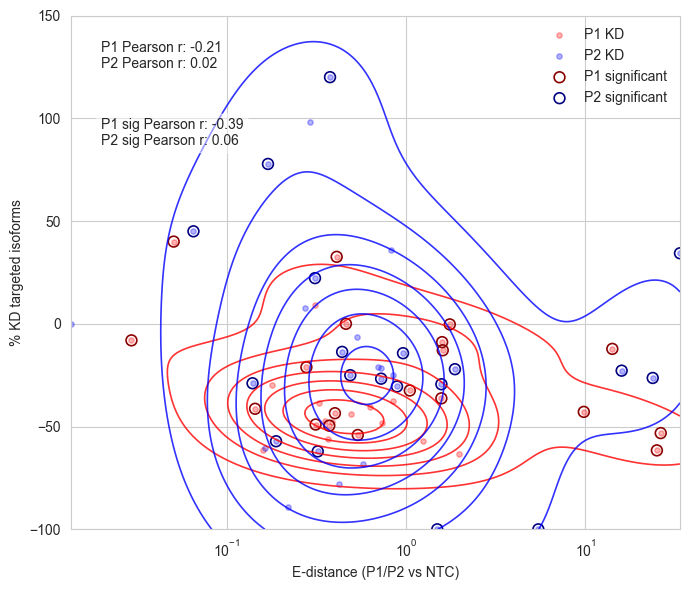

In [22]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

# Pull arrays
x1 = df_clean[x_p1].values          # e-distance (same for P1 & P2)
y1 = df_clean[y_p1].values         # %KD P1
x2 = df_clean[x_p2].values          # e-distance (same for P1 & P2)
y2 = df_clean[y_p2].values         # %KD P2
sig = df_clean[sig_col].values     # boolean significance

# Keep only positive x for log scale
mask = x1 > 0
x1 = x1[mask]
x2 = x2[mask]
y1 = y1[mask]
y2 = y2[mask]
sig = sig[mask]

# Work in log10(x) space for KDE stability
x1_log = np.log10(x1)
x2_log = np.log10(x2)


# Grid for KDE evaluation
xmin, xmax = min(x1_log.min(), x2_log.min()), max(x1_log.max(), x2_log.max())
ymin = min(y1.min(), y2.min())
ymax = max(y1.max(), y2.max())

xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]

# 2D KDE for P1
kde1 = gaussian_kde(np.vstack([x1_log, y1]))
z1 = kde1(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

# 2D KDE for P2
kde2 = gaussian_kde(np.vstack([x2_log, y2]))
z2 = kde2(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

# Convert grid x back to linear scale for plotting
x_grid = 10**xx

fig, ax = plt.subplots(figsize=(7, 6))

# --- KDE contours (sns.kdeplot-style) --- #
# P1: red contour lines
c1 = ax.contour(
    x_grid, yy, z1,
    levels=7,
    colors="red",
    linewidths=1.2,
    alpha=0.8,
)

# P2: blue contour lines
c2 = ax.contour(
    x_grid, yy, z2,
    levels=7,
    colors="blue",
    linewidths=1.2,
    alpha=0.8,
)

# --- Scatter points --- #
# Light, semi-transparent points
ax.scatter(x1, y1, c="red", s=15, alpha=0.3, label="P1 KD")
ax.scatter(x2, y2, c="blue", s=15, alpha=0.3, label="P2 KD")

# Highlight significant e-distance points with outlined markers
ax.scatter(
    x1[sig], y1[sig],
    facecolors="none", edgecolors="darkred",
    s=60, linewidth=1.2, label="P1 significant"
)
ax.scatter(
    x2[sig], y2[sig],
    facecolors="none", edgecolors="navy",
    s=60, linewidth=1.2, label="P2 significant"
)

# Axes & labels
ax.set_xscale("log")
ax.set_xlabel("E-distance (P1/P2 vs NTC)")
ax.set_ylabel("% KD targeted isoforms")
ax.set_ylim(-100, 150)
#add correlation
from scipy.stats import pearsonr
corr_p1, _ = pearsonr(x1, y1)
corr_p2, _ = pearsonr(x2, y2)
ax.text(0.05, 0.95, f'P1 Pearson r: {corr_p1:.2f}\nP2 Pearson r: {corr_p2:.2f}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
       )
# add correlation for significant points only
corr_p1_sig, _ = pearsonr(x1[sig], y1[sig])
corr_p2_sig, _ = pearsonr(x2[sig], y2[sig])
ax.text(0.05, 0.80, f'P1 sig Pearson r: {corr_p1_sig:.2f}\nP2 sig Pearson r: {corr_p2_sig:.2f}',    
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
       )
ax.legend(frameon=False)
#save
#print all the correlatiosn
print(f'P1 Pearson r: {corr_p1:.2f}\nP2 Pearson r: {corr_p2:.2f}')
print(f'P1 sig Pearson r: {corr_p1_sig:.2f}\nP2 sig Pearson r: {corr_p2_sig:.2f}')

fig.savefig(fig_loc+"edistance_kde_contours.pdf")
plt.tight_layout()
plt.show()

In [80]:
# plot TPM Non-Targeted P1 Isoforms sum TPM Non-Targeted P2 Isoforms % KD of Targeted P2 Isoforms against NTC
#add df
#make a column saying the proportion fo sum TPMTargeted P1 Isoforms over total TPM isoforms
df['proportion_TPM_P1'] = df['sum TPM Targeted P1 Isoforms'] / (df['sum TPM Targeted P1 Isoforms'] + df['sum TPM Targeted P2 Isoforms'])
df['proportion_TPM_P2'] = df['sum TPM Targeted P2 Isoforms'] / (df['sum TPM Targeted P1 Isoforms'] + df['sum TPM Targeted P2 Isoforms'])
#what i need is to plot sns.pairplot 
df_filt=df[df["successfulKD"]==True]

#read in loc+"files/singlecell_shortread_analysis/differential_exp_directional_genes.csv",
deg = pd.read_csv(loc+"files/singlecell_shortread_analysis/differential_exp_directional_genes.csv", index_col=0)
deg['gene']=deg.index.str.split("_").str.get(0)
#merge df_clean with deg on gene and plot the significant genes
#sum the number of significant genes per gene per promoter irrespective of direction "P1 Gene Count" "P2 Gene Count"
deg_summary = deg.groupby(['gene'])[['P1 Gene Count', 'P2 Gene Count']].sum().reset_index()
df_merged=df_filt.merge(deg_summary, left_on="gene", right_on="gene", how="left", suffixes=('', '_deg'))


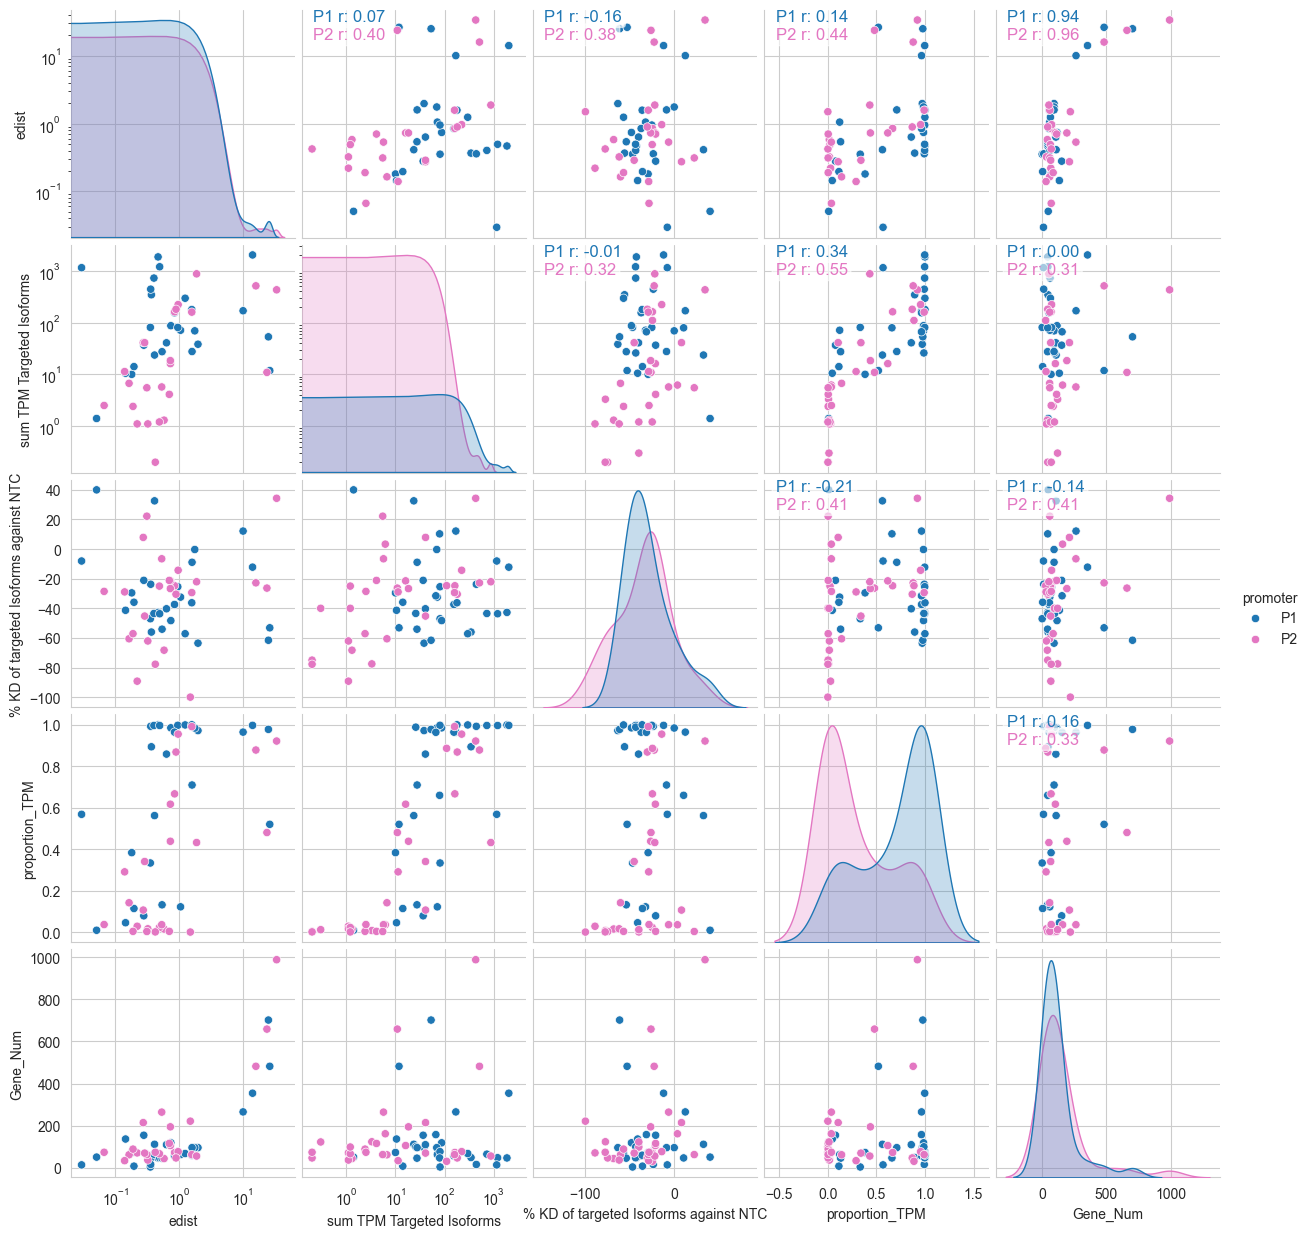

In [87]:

p1_col=['edist_P1','significant_P1', 'pvalue_adj_P1', 'promoter_P1', 'gene', 'sum TPM Targeted P1 Isoforms',  '% KD of targeted P1 Isoforms against NTC', 'proportion_TPM_P1',"P1 Gene Count"]
p2_col=['edist_P2','significant_P2', 'pvalue_adj_P2', 'promoter_P2', 'gene', 'sum TPM Targeted P2 Isoforms',  '% KD of Targeted P2 Isoforms against NTC', 'proportion_TPM_P2', "P2 Gene Count"]
df_p1=df_merged[p1_col]
df_p2=df_merged[p2_col]
df_p1.columns=['edist','significant', 'pvalue_adj', 'promoter', 'gene', 'sum TPM Targeted Isoforms',  '% KD of targeted Isoforms against NTC', 'proportion_TPM',"Gene_Num"]
df_p2.columns=['edist','significant', 'pvalue_adj', 'promoter', 'gene', 'sum TPM Targeted Isoforms',  '% KD of targeted Isoforms against NTC', 'proportion_TPM', "Gene_Num"]
df_melt=pd.concat([df_p1,df_p2])
#log x-axis for edist
#plot pairplot
#log10 ofsum TPM Targeted Isoforms
#filter above -20
#reset index
df_melt.reset_index(drop=True, inplace=True)
#add correlation coefficients to the upper plots
g = sns.pairplot(
    df_melt,
    diag_kind='kde',
    vars=['edist', 'sum TPM Targeted Isoforms',
          '% KD of targeted Isoforms against NTC', 'proportion_TPM',"Gene_Num"],
    hue='promoter',
    palette={"P1": 'tab:blue', "P2": 'tab:pink'}
)
# set x-axis to log scale for edist and sum TPM Targeted Isoforms
for ax in g.axes.flatten():
    if ax is not None:
        if ax.get_xlabel() == 'edist' or ax.get_xlabel() == 'sum TPM Targeted Isoforms':
            ax.set_xscale('log')
        if ax.get_ylabel() == 'edist' or ax.get_ylabel() == 'sum TPM Targeted Isoforms':
            ax.set_yscale('log')
vars_list = ['edist', 'sum TPM Targeted Isoforms',
             '% KD of targeted Isoforms against NTC', 'proportion_TPM',"Gene_Num"]
n = len(vars_list)
hues = list(df_melt['promoter'].unique())
palette_map = {"P1": 'tab:blue', "P2": 'tab:pink'}

# Annotate upper triangle with per-hue Pearson r, stacked to avoid overlap
for i in range(n):
    for j in range(i + 1, n):
        ax = g.axes[i, j]
        for k, h in enumerate(hues):
            mask = df_melt['promoter'] == h
            x = df_melt.loc[mask, vars_list[j]].values
            y = df_melt.loc[mask, vars_list[i]].values
            # require at least 2 finite points
            good = np.isfinite(x) & np.isfinite(y)
            if good.sum() < 2:
                r_text = f"{h} r: N/A"
            else:
                r, _ = pearsonr(x[good], y[good])
                r_text = f"{h} r: {r:.2f}"
            ypos = 0.95 - k * 0.08  # stack vertically to avoid overlap
            ax.annotate(
                r_text,
                xy=(0.05, ypos),
                xycoords='axes fraction',
                fontsize=12,
                color=palette_map.get(h, 'black'),
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.6)
            )
#change the x and y labels to be Log E-distance, Log Sum TPM Targeted Isoforms, % KD of targeted Isoforms against NTC, Proportion TPM


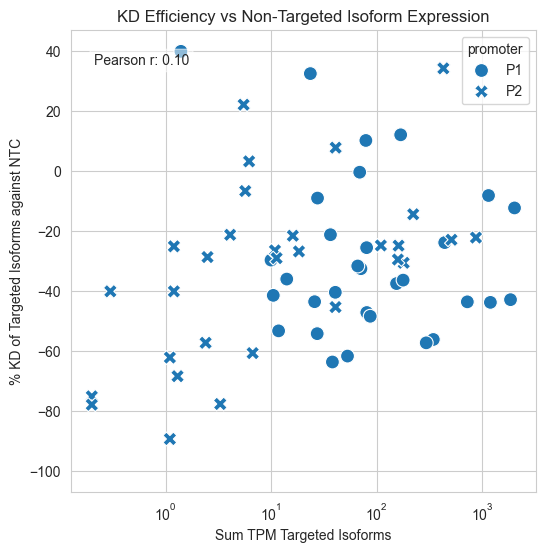

In [ ]:
# plot TPM Non-Targeted P1 Isoforms sum TPM Non-Targeted P2 Isoforms % KD of Targeted P2 Isoforms against NTC
#add df
p1_subset = df[['gene', 'sum TPM Targeted P1 Isoforms', 'edist_P1', '% KD of targeted P1 Isoforms against NTC', 'significant_P1']]
p1_subset.columns = ['gene', 'TPM_NT', 'edist_P1', '%KD', 'significant']
p1_subset['promoter'] = 'P1'
p2_subset = df[['gene', 'sum TPM Targeted P2 Isoforms', 'edist_P2', '% KD of Targeted P2 Isoforms against NTC', 'significant_P2']]
p2_subset.columns = ['gene', 'TPM_NT', 'edist_P2', '%KD', 'significant']
p2_subset['promoter'] = 'P2'
combined_df = pd.concat([p1_subset, p2_subset], ignore_index=True)
#filter successful KD only
combined_df = combined_df[combined_df['gene'].isin(df[df['successfulKD']==True]['gene'])]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(data=combined_df, x='TPM_NT', y='%KD',  style='promoter', s=100, ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Sum TPM Targeted Isoforms')
ax.set_ylabel('% KD of Targeted Isoforms against NTC')
#add correlation
from scipy.stats import pearsonr
corr, _ = pearsonr(combined_df['TPM_NT'], combined_df['%KD'])
ax.text(0.05, 0.95, f'Pearson r: {corr:.2f}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
       )
plt.show()
#save fig
fig.savefig(fig_loc+"kd_efficiency_vs_ntc_expression.pdf")


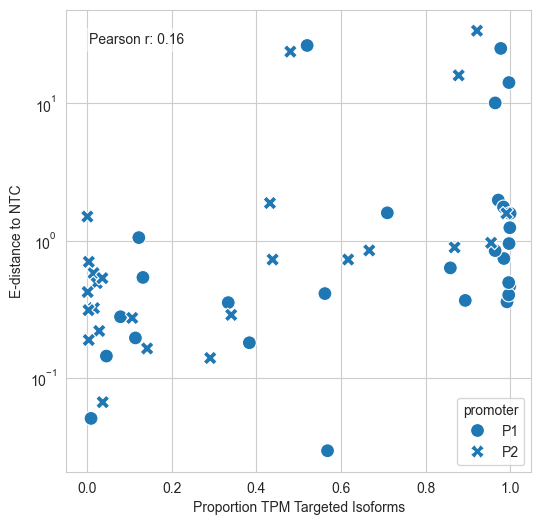

In [66]:
# plot TPM Non-Targeted P1 Isoforms sum TPM Non-Targeted P2 Isoforms % KD of Targeted P2 Isoforms against NTC
#add df
p1_subset = df[['gene', 'proportion_TPM_P1', 'edist_P1', '% KD of targeted P1 Isoforms against NTC', 'significant_P1']]
p1_subset.columns = ['gene', 'proportion_TPM', 'edist', '%KD', 'significant']
p1_subset['promoter'] = 'P1'
p2_subset = df[['gene', 'proportion_TPM_P2', 'edist_P2', '% KD of Targeted P2 Isoforms against NTC', 'significant_P2']]
p2_subset.columns = ['gene', 'proportion_TPM', 'edist', '%KD', 'significant']
p2_subset['promoter'] = 'P2'
combined_df = pd.concat([p1_subset, p2_subset], ignore_index=True)
#filter successful KD only
combined_df = combined_df[combined_df['gene'].isin(df[df['successfulKD']==True]['gene'])]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(data=combined_df, x='proportion_TPM', y='edist',  style='promoter', s=100, ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Proportion TPM Targeted Isoforms')
ax.set_ylabel('E-distance to NTC')
#add correlation
from scipy.stats import pearsonr
corr, _ = pearsonr(combined_df['proportion_TPM'], combined_df['%KD'])
ax.text(0.05, 0.95, f'Pearson r: {corr:.2f}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
       )
plt.show()
#save fig
fig.savefig(fig_loc+"kd_efficiency_vs_ntc_expression.pdf")


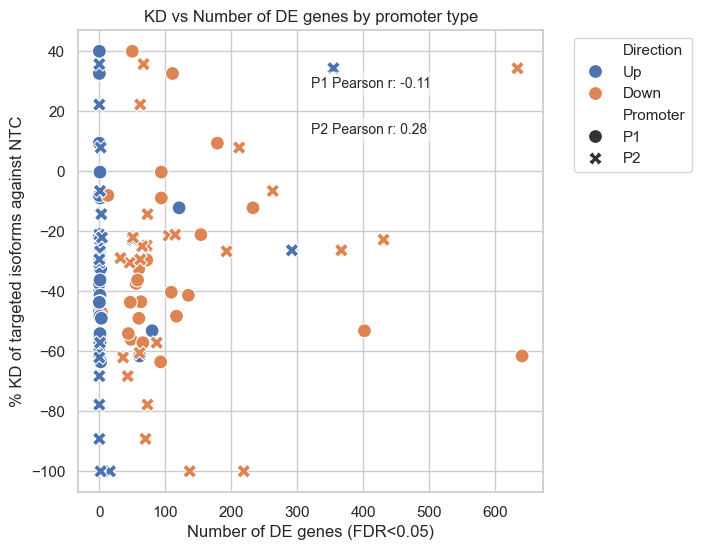

In [209]:
#plot % KD of targeted P1 Isoforms against NTC  % KD of Targeted P2 Isoforms against NTC against MP_Gene_Num and AP_Gene_Num with Direction 
fig, ax = plt.subplots(1,1, figsize=(6,6))
#nmelt df_merged to have one column for % KD and one for promoter type
#select % KD of targeted P1 Isoforms against NTC  and MP_Gene_Num and Overlap direction and add to top
df_melted_p1=df_merged[["gene","% KD of targeted P1 Isoforms against NTC","MP_Gene_Num","Direction"]]
df_melted_p1.columns=["gene","% KD","Gene_Num","Direction"]
df_melted_p1["Promoter"]="P1"
#select % KD of Targeted P2 Isoforms against NTC  and AP_Gene
df_melted_p2=df_merged[["gene","% KD of Targeted P2 Isoforms against NTC","AP_Gene_Num","Direction"]]
df_melted_p2.columns=["gene","% KD","Gene_Num","Direction"]
df_melted_p2["Promoter"]="P2"
df_melted=pd.concat([df_melted_p1,df_melted_p2], ignore_index=True)
#drop nas 
df_melted=df_melted.dropna(subset=["% KD","Gene_Num"])
sns.scatterplot(data=df_melted, x='Gene_Num', y='% KD', hue='Direction', style='Promoter', s=100)
plt.title('KD vs Number of DE genes by promoter type')
plt.xlabel('Number of DE genes (FDR<0.05)')
plt.ylabel('% KD of targeted isoforms against NTC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#also add correlation coefficent
for promoter in ['P1','P2']:
    subset = df_melted[df_melted['Promoter'] == promoter]
    corr, _ = pearsonr(subset['Gene_Num'], subset['% KD'])
    plt.text(0.5, 0.9 if promoter == 'P1' else 0.8, f'{promoter} Pearson r: {corr:.2f}',
             transform=ax.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()